## Py-DDA example notebook

This notebooks shows how you can get multiple Doppler winds from different radars. All that is needed are Cf-Compliant grids that share the same grid specifications. Tools such as Python ARM Radar Toolkit (Py-ART) (https://github.com/ARM-DOE/pyart) and LROSE (https://www.eol.ucar.edu/content/lidar-radar-open-software-environment) can create these grids for you. 

The PyDDA package is built on top of Py-ART. Therefore, Py-ART is needed for PyDDA to run. 

In [1]:
import pyart
import pydda
%pylab inline
import warnings
warnings.filterwarnings("ignore")


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

Populating the interactive namespace from numpy and matplotlib


/home/rjackson/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


First, we load our Cf-Compliant grids using Py-ART's read_grid function.

In [2]:
berr_grid = pyart.io.read_grid("/home/rjackson/data/berr_Darwin_hires.nc")
cpol_grid = pyart.io.read_grid("/home/rjackson/data/cpol_Darwin_hires.nc")
print(cpol_grid.fields.keys())

dict_keys(['EL', 'DT', 'ROI', 'VT', 'AZ'])


Next, we must specify the initial conditions. PyDDA currently has two options for the intial state:

    * pydda.retrieval.make_wind_field_from_profile - Make the intialization wind field be that from a sounding    
    * pydda.retrieval.make_constant_wind_field - Specify a constant wind field 
    
More options will be added in the future! In this example, we will load data from a sounding and use that as our intial state with no vertical motion. 
    

In [3]:
sounding = pyart.io.read_arm_sonde(
    "/home/rjackson/data/soundings/twpsondewnpnC3.b1.20060119.231600.custom.cdf")
print(sounding)
u_init, v_init, w_init = pydda.initialization.make_wind_field_from_profile(
        cpol_grid, sounding[1], vel_field='VT')

(datetime.datetime(2006, 1, 19, 23, 16), <pyart.core.wind_profile.HorizontalWindProfile object at 0x7f9b18cc2390>)


Next, we will retrieve the wind field! The output of these is a list of Py-ART Grids which correspond to the inputs with the wind fields added in. 

In [4]:
Grids = pydda.retrieval.get_dd_wind_field([berr_grid, cpol_grid], u_init,
                                          v_init, w_init, Co=100.0, Cm=1500.0, 
                                          Cz=0, vel_name='VT', refl_field='DT',
                                          frz=5000.0, filt_iterations=0, 
                                          mask_outside_opt=True, upper_bc=1)

Calculating weights for radars 0 and 1
Starting solver 
rmsVR = 40.299436641264535
Total points:172054.0
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Max w  
|  16.7897| 126.1735|   0.0000|   0.0000|   0.0000|   8.0825
Norm of gradient: 0.0320252073946393
Iterations before filter: 10
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Max w  
|   1.7514|  43.2693|   0.0000|   0.0000|   0.0000|   8.7247
Norm of gradient: 0.00980930367243487
Iterations before filter: 20
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Max w  
|   3.4044|  25.6647|   0.0000|   0.0000|   0.0000|  14.9730
Norm of gradient: 0.01957781853933416
Iterations before filter: 30
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Max w  
|   1.0347|  23.3177|   0.0000|   0.0000|   0.0000|  17.2227
Norm of gradient: 0.013950840550118736
Iterations before filter: 40
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Max w  
|   0.4310|  23.5386|   0.0000|   0.0000|   0.0000|  17.7904
Norm of gradient: 0.01

Let's save our grid so we don't have to regenerate it again!

In [5]:
pyart.io.write_grid('example_grid_radar0.nc', Grids[0])
pyart.io.write_grid('example_grid_radar1.nc', Grids[1])

In [6]:
Grids = [pyart.io.read_grid('example_grid_radar0.nc'), pyart.io.read_grid('example_grid_radar1.nc')]

Finally, we will visualize the wind field. This is easy with the visualization module of PyDDA! PyDDA currently has support to plot wind barb plots through xy, xz, and yz cross sections. More types of plots (streamline plots, plots on geospatial grids) are planned as future features.

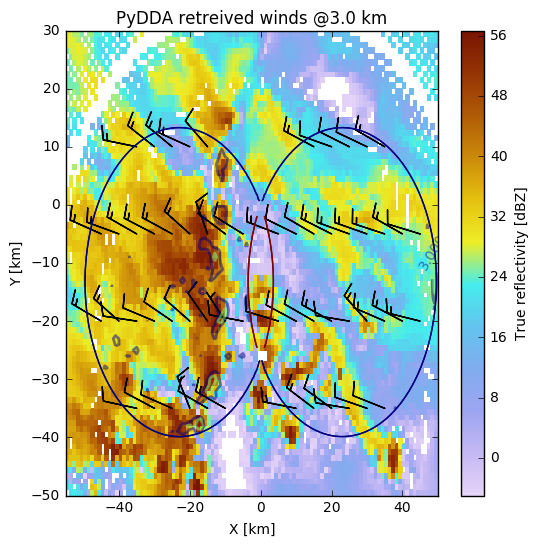

In [7]:
plt.figure(figsize=(6,6))
pydda.vis.plot_horiz_xsection_barbs(Grids, None, 'DT', level=6,
                                    w_vel_contours=[3, 6, 9],
                                    barb_spacing_x_km=5.0,
                                    barb_spacing_y_km=15.0)

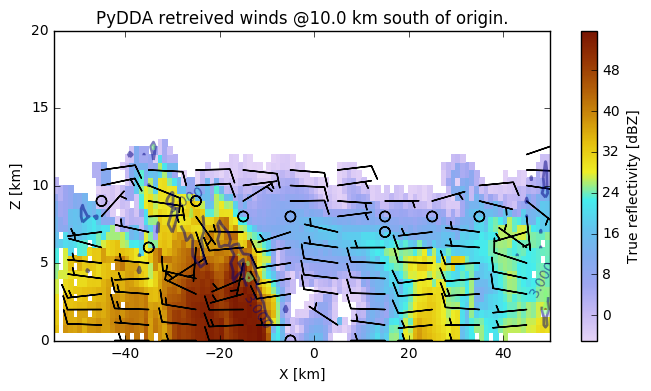

In [8]:
plt.figure(figsize=(8,4))
pydda.vis.plot_xz_xsection_barbs(Grids, None, 'DT', level=40,
                                 w_vel_contours=[3, 6, 9],
                                 barb_spacing_x_km=10.0,
                                 barb_spacing_z_km=2.0)

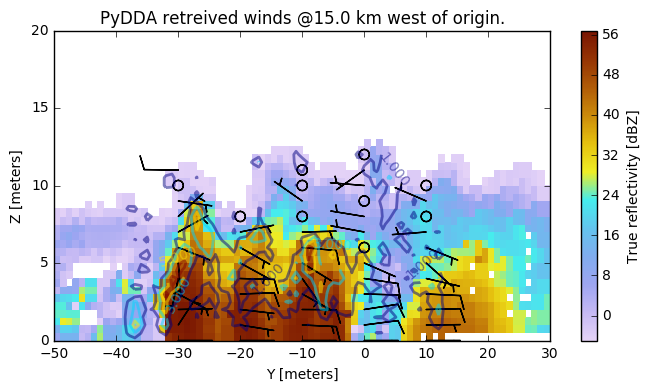

In [9]:
plt.figure(figsize=(8,4))
pydda.vis.plot_yz_xsection_barbs(Grids, None,'DT', level=40,
                                 w_vel_contours=[1, 3, 5, 7],
                                 barb_spacing_y_km=10.0,
                                 barb_spacing_z_km=2.0)

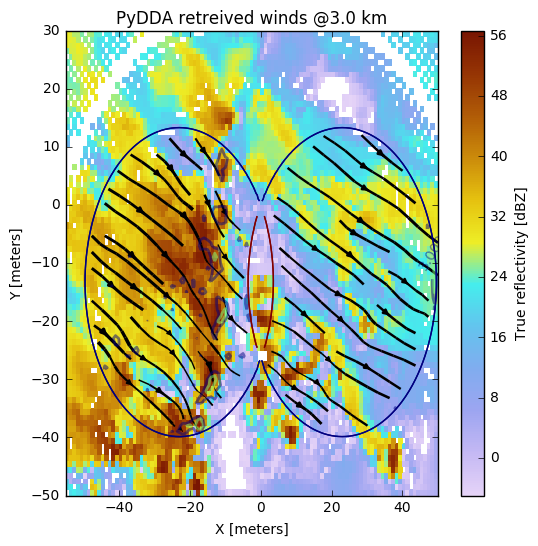

In [10]:
plt.figure(figsize=(6,6))
pydda.vis.plot_horiz_xsection_streamlines(Grids, None, 'DT', level=6,
                                          w_vel_contours=[3, 6, 9],
                                          )

(0, 15)

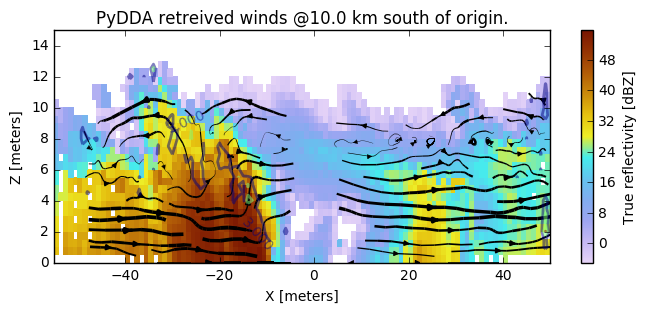

In [13]:
plt.figure(figsize=(8,3))
pydda.vis.plot_xz_xsection_streamlines(Grids, None, 'DT', level=40,
                                 w_vel_contours=[3, 6, 9],
                                 thickness_divisor=5.0)
plt.ylim([0,15])

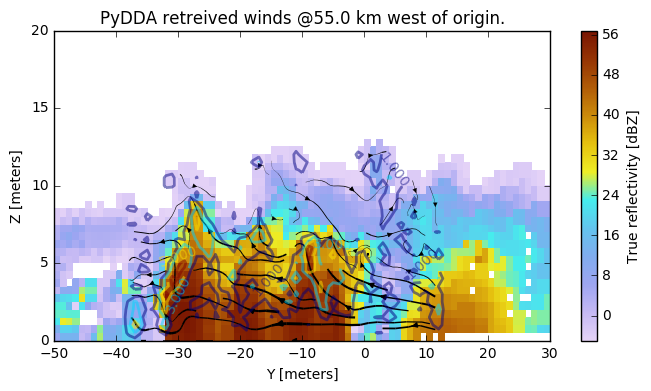

In [12]:
plt.figure(figsize=(8,4))
pydda.vis.plot_yz_xsection_streamlines(Grids, None,'DT', level=40,
                                 w_vel_contours=[1, 3, 5, 7],
                                 )